In [6]:
# Import necessary libraries
from __future__ import absolute_import, division, print_function

%matplotlib inline

import sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import axes3d

print("Version information")

print("python: {}".format(sys.version))
print("matplotlib: {}".format(matplotlib.__version__))
print("numpy: {}".format(np.__version__))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from naivebayes import EmotionClassifier, cross_validate_evaluate

import nltk
nltk.download('punkt')


Version information
python: 3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]
matplotlib: 3.7.4
numpy: 1.24.3


[nltk_data] Downloading package punkt to /Users/parag/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
# Load the dataset
df = pd.read_csv("../text.csv")
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


This Jupyter Notebook will guide you through the process of training all the models to classify emotions in text. It covers the preprocessing of text data, training the model, evaluating its performance using cross-validation, and finally visualizing the results using a confusion matrix.

# Emotion Classifier using Naive Bayes

### Reference: Emotions classified into six categories: sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5)

In [7]:
# Preprocess the text
df['processed_text'] = df['text'].apply(EmotionClassifier.preprocess_text)
df.head()

,Unnamed: 0,text,label,processed_text
0,0,i just feel really helpless and heavy hearted,4,i just feel really helpless and heavy hearted
1,1,ive enjoyed being able to slouch about relax a...,0,ive enjoyed being able to slouch about relax a...
2,2,i gave up my internship with the dmrg and am f...,4,i gave up my internship with the dmrg and am f...
3,3,i dont know i feel so lost,0,i dont know i feel so lost
4,4,i am a kindergarten teacher and i am thoroughl...,4,i am a kindergarten teacher and i am thoroughl...


In [8]:
# Convert data for cross-validation
X = df['processed_text'].to_numpy()
y = df['label'].to_numpy()

# Perform cross-validation and evaluate the model
acc, prec, f1, cm = cross_validate_evaluate(X, y)

print("Average Accuracy:", np.mean(acc))
print("Average Precision:", np.mean(prec))
print("Average F1-Score:", np.mean(f1))


Average Accuracy: 0.4064907407627499
Average Precision: 0.45094832020382825
Average F1-Score: 0.4169481168357446


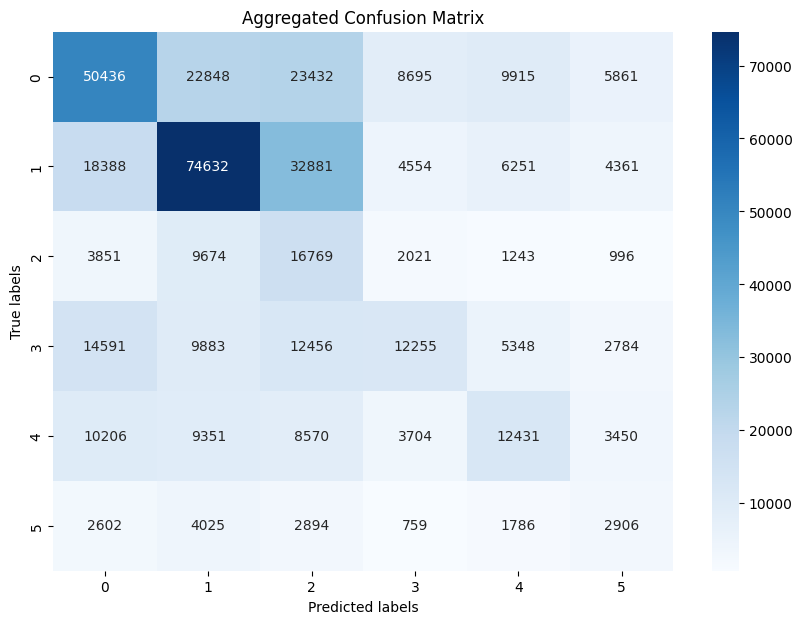

In [9]:
# Plot the aggregated confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Aggregated Confusion Matrix')
plt.show()

# Emotion Classifier using Linear SVM

In [11]:
import re
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

In [8]:
class EmotionClassifier:
    def __init__(self):
        self.model = SVC(kernel='linear') 
        self.vectorizer = CountVectorizer()

    def train(self, X_train, y_train):
        X_train_vect = self.vectorizer.fit_transform(X_train)
        self.model.fit(X_train_vect, y_train)

    def predict(self, X):
        X_vect = self.vectorizer.transform(X)
        return self.model.predict(X_vect)
    
    @staticmethod
    def preprocess_text(text):
        text = text.lower()
        text = re.sub(r"[^a-zA-Z0-9\s]", '', text)
        tokens = word_tokenize(text)
        negation_terms = {'not', 'no', 'never', 'none'}
        tokens = ['not_' + tokens[i+1] if tokens[i] in negation_terms and i+1 < len(tokens) else token 
                  for i, token in enumerate(tokens)]
        return ' '.join(tokens)


### Reference: Emotions classified into six categories: sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5)

In [9]:
# Load data
df = pd.read_csv('../text.csv')
df['processed_text'] = df['text'].apply(EmotionClassifier.preprocess_text)

# displaying first few rows to confirm preprocessing
df.head()


,Unnamed: 0,text,label,processed_text
0,0,i just feel really helpless and heavy hearted,4,i just feel really helpless and heavy hearted
1,1,ive enjoyed being able to slouch about relax a...,0,ive enjoyed being able to slouch about relax a...
2,2,i gave up my internship with the dmrg and am f...,4,i gave up my internship with the dmrg and am f...
3,3,i dont know i feel so lost,0,i dont know i feel so lost
4,4,i am a kindergarten teacher and i am thoroughl...,4,i am a kindergarten teacher and i am thoroughl...


In [12]:
def cross_validate_evaluate(X, y):
    kf = KFold(n_splits=5, random_state=42, shuffle=True) 
    acc_scores, prec_scores, f1_scores = [], [], []
    aggregated_cm = np.zeros((6, 6)) 

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        classifier = EmotionClassifier()
        classifier.train(X_train, y_train)
        y_pred = classifier.predict(X_test)

        acc_scores.append(accuracy_score(y_test, y_pred))
        prec_scores.append(precision_score(y_test, y_pred, average='weighted'))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
        cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
        aggregated_cm += cm

    return acc_scores, prec_scores, f1_scores, aggregated_cm


In [13]:
# data converted to numpy arrays for cross-validation
X = df['processed_text'].to_numpy()
y = df['label'].to_numpy()

acc, prec, f1, cm = cross_validate_evaluate(X, y)

print(f"Average Accuracy: {np.mean(acc)}")
print(f"Average Precision: {np.mean(prec)}")
print(f"Average F1-Score: {np.mean(f1)}")


In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Aggregated Confusion Matrix')
plt.show()

# Emotion Classifier using SVM with RBF Kernel (non-Linear SVM)

In [1]:
class EmotionClassifier:
    def __init__(self):
        self.model = SVC(kernel='rbf') 
        self.vectorizer = CountVectorizer()

    def train(self, X_train, y_train):
        X_train_vect = self.vectorizer.fit_transform(X_train)
        self.model.fit(X_train_vect, y_train)

    def predict(self, X):
        X_vect = self.vectorizer.transform(X)
        return self.model.predict(X_vect)
    
    @staticmethod
    def preprocess_text(text):
        text = text.lower()
        text = re.sub(r"[^a-zA-Z0-9\s]", '', text)
        tokens = word_tokenize(text)
        negation_terms = {'not', 'no', 'never', 'none'}
        tokens = ['not_' + tokens[i+1] if tokens[i] in negation_terms and i+1 < len(tokens) else token 
                  for i, token in enumerate(tokens)]
        return ' '.join(tokens)


In [4]:
df = pd.read_csv('../text.csv')
df['processed_text'] = df['text'].apply(EmotionClassifier.preprocess_text)

df.head()

NameError: name 'pd' is not defined

In [ ]:
def cross_validate_evaluate(X, y):
    kf = KFold(n_splits=2, random_state=42, shuffle=True)
    acc_scores, prec_scores, f1_scores = [], [], []
    aggregated_cm = np.zeros((6, 6))  

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        classifier = EmotionClassifier()
        classifier.train(X_train, y_train)
        y_pred = classifier.predict(X_test)

        acc_scores.append(accuracy_score(y_test, y_pred))
        prec_scores.append(precision_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred)))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred)))
        cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
        aggregated_cm += cm

    return acc_scores, prec_scores, f1_scores, aggregated_cm

In [ ]:
X = df['processed_text'].to_numpy()
y = df['label'].to_numpy()

acc, prec, f1, cm = cross_validate_evaluate(X, y)

print(f"Average Accuracy: {np.mean(acc)}")
print(f"Average Precision: {np.mean(prec)}")
print(f"Average F1-Score: {np.mean(f1)}")


In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Aggregated Confusion Matrix')
plt.show()

# Emotion Classification using BERT

In [5]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
from datetime import datetime

In [7]:
# Load data
datasetPath = '../text.csv'  # Adjust the path accordingly
df = pd.read_csv(datasetPath)
texts = df['text'].tolist()
labels = df['label'].tolist()  # Example labels: 0:anger, 1:fear, etc.

# splitting data
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)


In [8]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 256
train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_len)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [9]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

ConnectionError: HTTPSConnectionPool(host='cdn-lfs.huggingface.co', port=443): Max retries exceeded with url: /bert-base-uncased/68d45e234eb4a928074dfd868cead0219ab85354cc53d20e772753c6bb9169d3?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1714004535&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNDAwNDUzNX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9iZXJ0LWJhc2UtdW5jYXNlZC82OGQ0NWUyMzRlYjRhOTI4MDc0ZGZkODY4Y2VhZDAyMTlhYjg1MzU0Y2M1M2QyMGU3NzI3NTNjNmJiOTE2OWQzP3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiJ9XX0_&Signature=kJIBUSbmVPwfHaBPvCpiPrAAggWPlutYyp3bnyuzpKvDl2qIaZQynUw2C1wkiQKOb9czuJ0KOBIIOQlUQPwERmcExAMg~d1jVuewRZ3~CET0rncR6XXm52c~nM4-S0AJ-35SJffSQC617id8CupfnbH7-lyb6zsoyuf9u~tHg7FABXdem8KPigCcERwoMg0it1w7BI2TJu4zF-ZXc2ZFeVDECXuS3UUMGWsk1S5rlKu5YV4SPOOabMy3~Ae7yN88FXHIlW9bRtAkQUbh9k71mfXELXud~mIrKTAPdSpXR4dhPcXs8Rzc9y-Bo4b7tijTpK7BpSeg8ns-veuWrSoh3Q__&Key-Pair-Id=KVTP0A1DKRTAX (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x169639050>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

In [ ]:
epochs = 6
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        outputs = model(batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['label'])
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {total_loss/len(train_loader):.4f}')


In [ ]:
# Use validation data to evaluate the model
# Ensure you switch the model to evaluation mode
model.eval()
# Follow similar steps as training to compute outputs
# Use precision_score, recall_score, f1_score from sklearn.metrics to compute the evaluation metrics
